In [2]:
% matplotlib inline
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
#from unidecode import unidecode #QUITO TILDES

In [3]:
# Cargar la data de properati
df = pd.read_csv('properatti.csv')  # DATOS DE PROPIEDADES EN VENTA PROPERATI


In [4]:
#Obtenemos un dataframe con los valores dummies del tipo de moneda
dummies_price = pd.get_dummies(df['currency'])

In [5]:
#Filtramos en una nueva columna los valores que están en ARS
df["ars"] = df["price"] * dummies_price["ARS"]
dummies_price["ARS"].value_counts()

0    108001
1     13219
Name: ARS, dtype: int64

In [6]:
ars = df["ars"]
ars.isnull().value_counts()

False    100810
True      20410
Name: ars, dtype: int64

In [7]:
#Calculamos el valor aproximado del USD según los precios que están en pesos "ars"
#y que tienen el precio aproximado en USD en la columna "price_aprox_usd" y lo guardamos
#en una nueva columna "USDaprox"
df["USDaprox"] = df["ars"] / (df["price_aprox_usd"] * dummies_price["ARS"])

In [8]:
#Miramos los estadísticos de la distribución del precio aproximado del USD
df["USDaprox"].describe()

count    13219.000000
mean        17.814183
std          0.102316
min         17.143000
25%         17.830500
50%         17.830501
75%         17.830502
max         17.830531
Name: USDaprox, dtype: float64

In [9]:
#Encontramos el valor que se utiliza en la mediana de los casos para el dólar
# y así trabajar con este valor para las aproximaciones que hagan falta
df["USDaprox"].median()

17.830501005171033

In [10]:
#Chequeamos de otra forma el valor del USD usando el precio por M2 en ars y en USD
#Dividiendo el precio en ars por el precio en USD
df["USDaprox1"] = df["price_per_m2"] / df["price_usd_per_m2"]

In [11]:
#Comprobamos que esta forma de aproximar el valor de USD no nos sirve. Los valores
#son muy dispersos así que trabajaremos con la mediana del cálculo anterior
df["USDaprox1"].describe()

count    63350.000000
mean         5.869295
std        158.413517
min          0.001061
25%          1.000000
50%          1.125000
75%          1.626609
max      23848.295570
Name: USDaprox1, dtype: float64

In [12]:
#Asignamos un valor a USD
USD = df["USDaprox"].median()

In [13]:
#Armamos una nueva columna donde vamos a imputar los precios por M2 en USD de forma que
#podamos usarlo como valorizador. Lo llenamos en principio con los valores de price_usd_per_m2
y = df.loc[(df["price_per_m2"] < 200000) & (df["price_per_m2"] > 100)]["price_per_m2"]/USD
df["newusd_per_m2"] = df["price_usd_per_m2"].fillna(y)

In [121]:
y.describe()

count    87490.000000
mean       354.619819
std        701.665609
min          5.703424
25%         86.929694
50%        124.073477
75%        187.754388
max      10936.316368
Name: price_per_m2, dtype: float64

In [15]:
df["newusd_per_m2"].describe()

count     92819.000000
mean       1685.418148
std        2531.729858
min           0.600000
25%         330.578512
50%        1461.574545
75%        2233.634386
max      206333.333333
Name: newusd_per_m2, dtype: float64

In [16]:
df["newusd_per_m2"].sample(30)

92356       91.110661
83708     1542.301000
30447     2000.000000
58487     2378.378378
17684      690.690691
23322     1133.606170
259       2106.299213
6160      1702.439024
45558     1041.553940
118707     435.483871
24402     1876.288660
7109       600.000000
73997     2333.333333
115056            NaN
10578     1461.538462
65986             NaN
103335     557.939914
62558      296.674506
35053             NaN
72151             NaN
101972            NaN
87722     1975.555556
66260      866.666667
62560      151.490383
85220     1045.454545
28485     2533.333333
36832             NaN
78198     2895.061728
2402              NaN
4374       394.444444
Name: newusd_per_m2, dtype: float64

In [17]:
#Continuamos imputando los NaN con los valores que podemos obtener
#de dividir el precio total en usd "price" por la superficie en M2

In [18]:
df["newprice_m2_ars"] = df["price"] / df["surface_total_in_m2"]
df["newprice_m2_usd"] = df["price"] / df["surface_total_in_m2"]
df["newprice_m2"] = df["newprice_m2_usd"]*dummies_price["USD"] + df["newprice_m2_ars"]*dummies_price["ARS"]/USD

In [19]:
#df["newprice_m2"].fillna(0, inplace=True)

In [20]:
newprice = df["newprice_m2"]

In [21]:
df["newusd_per_m2"] = df["newusd_per_m2"].fillna(newprice)

In [22]:
df["newusd_per_m2"].isna().sum()

28401

In [23]:
df["newusd_per_m2"].describe()

count     92819.000000
mean       1685.418148
std        2531.729858
min           0.600000
25%         330.578512
50%        1461.574545
75%        2233.634386
max      206333.333333
Name: newusd_per_m2, dtype: float64

In [24]:
dfPrecio = df.loc[:,['place_name','property_type']].copy()
dfPrecio['place_name_id'] = df['place_name'].astype('category').cat.codes
dfPrecio['property_type_id'] = df['property_type'].astype('category').cat.codes
dfPrecio['currency_id'] = df['currency'].astype('category').cat.codes

In [25]:
dfPrecio['precio_calculado']=df['newusd_per_m2']
dfPrecio = pd.concat([dfPrecio, dummies_price], axis=1);
dfPrecio2=dfPrecio

In [26]:
dfPrecio["precio_calculado"] = dfPrecio.groupby(['place_name_id','property_type_id'])['precio_calculado'].transform(lambda x: x.fillna(x.median()))
print('Sin Imputar:',dfPrecio["precio_calculado"].isna().sum() )
dfPrecio["precio_calculado"].describe()
print('Imputados:',dfPrecio[(~dfPrecio['precio_calculado'].isna()) ]['precio_calculado'].count())
print('Mediana Imputados:',dfPrecio[(~dfPrecio['precio_calculado'].isna()) ]['precio_calculado'].median())

/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Sin Imputar: 632
Imputados: 120588
Mediana Imputados: 1384.5905048076922


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


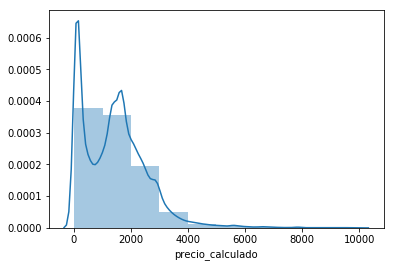

In [27]:
sns.distplot(dfPrecio[(dfPrecio['precio_calculado']<10000) & (dfPrecio['precio_calculado']>10)]['precio_calculado'], bins=10)

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


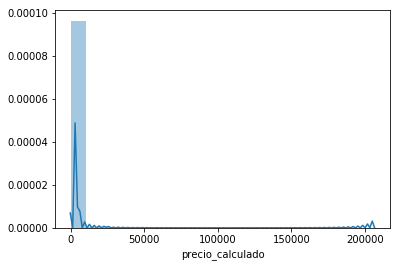

In [28]:
sns.distplot(dfPrecio['precio_calculado'].dropna(), bins=20)

In [29]:
dfPrecio["surface_total_in_m2"] = df["surface_total_in_m2"]

In [30]:
dfPrecio["precio_calculado"].dropna().head()

0    1127.272727
1    1320.512821
2    1309.090909
3    1277.777778
4    1828.571429
Name: precio_calculado, dtype: float64

## Top 10 de zonas por precio/m2 en USD

In [32]:
#Top 10 por valor m2 de propiedad
dfPrecio.groupby('place_name')['precio_calculado'].mean().sort_values(ascending = False).head(10)

place_name
Alejandro Roca             24038.461538
San Francisco del Monte    15833.333333
Boedo                       9928.968417
St. Patrick Country         8048.309179
San Cristobal               7537.027362
Monte Cristo                6400.000000
Villa Nueva                 6276.150628
Puerto Madero               5335.427190
Cafayate                    5047.530632
Guillermo Hudson            4722.222222
Name: precio_calculado, dtype: float64

## Top 10 de zonas por precio/m2 en USD filtrando valores > USD15.000

In [94]:
price_new = dfPrecio[(dfPrecio['precio_calculado']<10000) & (dfPrecio['precio_calculado']>1)]

In [97]:
print(price_new.groupby('place_name')['precio_calculado'].median().sort_values(ascending = False).head(10))

place_name
Monte Cristo           6400.000000
Villa Nueva            6276.150628
Puerto Madero          5620.192308
Cafayate               5047.530632
Guillermo Hudson       4722.222222
Arroyo Ceibal          4486.693895
Capilla del Rosario    4375.000000
Palermo Chico          4140.476190
Colastiné              3925.857158
Manzone                3657.074468
Name: precio_calculado, dtype: float64


In [ ]:
sns.boxplot

## Top 10 zonas por tamaños de superficie

In [81]:
dfPrecio.groupby('place_name')['surface_total_in_m2'].median().sort_values(ascending = False).head(10)

place_name
Zárate                        26597.5
Los Molinos                   22593.0
El Trapiche                   18000.0
Campo Quijano                 17892.5
Monte Vera                    11111.0
Uribelarrea                   10200.0
Corcovado                     10000.0
La Esperanza Club de Campo     9053.0
Tornquist                      6000.0
Villa Icho Cruz                4850.0
Name: surface_total_in_m2, dtype: float64

## Boxplot de Precio por Tipo de Propiedad

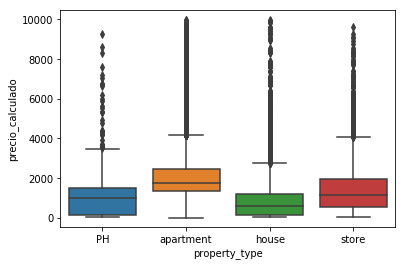

In [95]:
sns.boxplot(x = price_new["property_type"], y= price_new["precio_calculado"].dropna())

## Pivot Table con Precios Promedio por Zona y tipo de Propiedad

In [42]:
price_new.pivot_table("precio_calculado", index='place_name', columns='property_type', aggfunc=np.mean)

property_type,PH,apartment,house,store
place_name,,,,
Country Maschwitz Club,NaN,NaN,928.513808,NaN
los alamos,NaN,1600.000000,NaN,NaN
9 de Abril,NaN,NaN,94.017094,111.940469
Abasto,1565.450682,1818.223873,189.253662,2040.227983
Abril Club de Campo,NaN,NaN,950.638046,NaN
Acacias Blancas,NaN,NaN,756.198791,NaN
Acassuso,1522.925575,2097.133324,1253.227347,1547.261376
Achiras,NaN,NaN,80.119534,NaN
Adrogué,951.000691,1802.737923,961.848280,1338.814889


## Zonas con mayor dispersión de precio USD/m2

In [98]:
price_new.groupby('place_name')['precio_calculado'].apply(lambda x: x.std() / x.mean()).sort_values(ascending = False).head(10)

place_name
Oberá                        2.463102
Los Lagartos Country Club    2.292768
Rafael Calzada               2.073748
Azul                         2.055348
Paso del Rey                 1.995192
Longchamps                   1.977373
Coronel Brandsen             1.974203
Trujui                       1.910999
Monte Chingolo               1.859225
Boca Ratón                   1.839771
Name: precio_calculado, dtype: float64